<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use XGBoost to classify tumors with IBM Watson Machine Learning</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png" alt="Icon" width="700"> </th>
   </tr>
</table>

This notebook contains steps and code to get data from the IBM Watson Studio Community, create a predictive model, and start scoring new data. This notebook introduces commands for getting data and for basic data cleaning and exploration, model training, model persistance to Watson Machine Learning repository, model deployment, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.5, XGBoost, and scikit-learn.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set, to train an XGBoost Model to classify breast cancer tumors (as benign or malignant) from 569 diagnostic images based on measurements such as radius, texture, perimeter and area. XGBoost is short for “E**x**treme **G**radient **Boost**ing”.

The XGBoost classifier makes its predictions based on the majority vote from collection of models which are a set of classification trees. It uses the combination of weak learners to create a single strong learner. It’s a sequential training process, whereby new learners focus on the misclassified examples of previous learners.


## Learning goals

You will learn how to:

-  Load a CSV file into numpy array
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate a model
-  Use cross-validation to optimize model's hyperparameters
-  Persist a model in Watson Machine Learning repository
-  Deploy a model for online scoring
-  Score sample data


## Contents

This notebook contains the following parts:

1.	[Set up the environment](#setup)
2.	[Load and explore the data](#load)
3.	[Create the XGBoost model](#model)
4.	[Persist model](#persistence)
5.	[Deploy and score in a Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you have to perform the following setup tasks:

- Create a [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
-  Download **Breast Cancer Wisconsin (Diagnostic) Data Set** dataset from Watson Studio [Community](https://dataplatform.ibm.com/community?context=analytics).

**Note:** We provide the code to download data set, see [step 2](#load).

<a id="load"></a>
## 2. Load and explore the data

In this section you will load the data as a numpy array and perform a basic exploration.

To load the data as a numpy array, user `wget` to download the data, then use the `genfromtxt` method to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only one time.<BR><BR>

In [ ]:
!pip install wget --upgrade

In [3]:
# Get the data.
import wget, os

WisconsinDataSet = 'BreastCancerWisconsinDataSet.csv' 
if not os.path.isfile(WisconsinDataSet):
    link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=941eec501eadcdceb5abd25cf7c029d5'
    WisconsinDataSet = wget.download(link_to_data)

print(WisconsinDataSet)

BreastCancerWisconsinDataSet.csv


The csv file **BreastCancerWisconsinDataSet.csv** is downloaded. Run the code in the next cells to load the file to the numpy array.

**Note:** Update `numpy` to ensure you have the latest version.

In [ ]:
# Run this code to upgrade numpy.
!pip install numpy --upgrade

In [5]:
import numpy as np

np_data = np.genfromtxt(WisconsinDataSet, delimiter=',', names=True, dtype=None, encoding='utf-8')
print(np_data[0])

(842302, 'M', 17.99, 10.38, 122.8, 1001., 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019., 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189)


Run the code in the next cell to view the feature names and data storage types.

In [6]:
# Display the feature names and data storage types.
print(np_data.dtype)

[('id', '<i8'), ('diagnosis', '<U1'), ('radius_mean', '<f8'), ('texture_mean', '<f8'), ('perimeter_mean', '<f8'), ('area_mean', '<f8'), ('smoothness_mean', '<f8'), ('compactness_mean', '<f8'), ('concavity_mean', '<f8'), ('concave_points_mean', '<f8'), ('symmetry_mean', '<f8'), ('fractal_dimension_mean', '<f8'), ('radius_se', '<f8'), ('texture_se', '<f8'), ('perimeter_se', '<f8'), ('area_se', '<f8'), ('smoothness_se', '<f8'), ('compactness_se', '<f8'), ('concavity_se', '<f8'), ('concave_points_se', '<f8'), ('symmetry_se', '<f8'), ('fractal_dimension_se', '<f8'), ('radius_worst', '<f8'), ('texture_worst', '<f8'), ('perimeter_worst', '<f8'), ('area_worst', '<f8'), ('smoothness_worst', '<f8'), ('compactness_worst', '<f8'), ('concavity_worst', '<f8'), ('concave_points_worst', '<f8'), ('symmetry_worst', '<f8'), ('fractal_dimension_worst', '<f8')]


In [7]:
# Display the number of records and features.
print('Number of rows: {}'.format(np_data.size))
print('Number of columns: {}'.format(len(np_data[0])))

Number of rows: 569
Number of columns: 32


You can see that the data set has 569 records and 32 features.

<a id="model"></a>
## 3. Create an XGBoost model

In this section you will learn how to train and test an XGBoost model.

- [3.1. Prepare the data](#prepare)
- [3.2. Create the XGBoost model](#create)

### 3.1. Prepare data<a id="prepare"></a>

Now, you can prepare your data for model building. You will use the `diagnosis` column as your target variable so you must remove it from the set of predictors. You must also remove the `id` variable.

In [8]:
y = 1.0*(np_data['diagnosis'] == 'M')
X = np.array([list(r)[2:] for r in np_data])

Split the data set into: 
- Train data set
- Test data set

In [ ]:
# Split the data set and create two data sets.
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [10]:
# List the number of records in each data set.
print("Number of training records: " + str(X_train.shape[0]))
print("Number of testing records : " + str(X_test.shape[0]))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set, which is the largest group, will be used for training
- The test data set will be used for model evaluation and is used to test the assumptions of the model

### 3.2. Create the XGBoost model<a id="create"></a>

Start by importing the necessary libraries.

In [ ]:
# Import the libraries you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

#### 3.2.1. Create an XGBoost classifier

In this section you create an XGBoost classifier with default hyperparameter values and you will call it *xgb_model*. 

**Note** The next sections show you how to improve this base model.

In [12]:
# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier()

Display the default parameters for *xgb_model*.

In [13]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'learning_rate': 0.1, 'min_child_weight': 1, 'silent': 1, 'reg_lambda': 1, 'seed': 0, 'subsample': 1, 'scale_pos_weight': 1, 'n_estimators': 100, 'base_score': 0.5, 'reg_alpha': 0, 'missing': None, 'max_delta_step': 0, 'gamma': 0, 'colsample_bylevel': 1, 'objective': 'binary:logistic', 'colsample_bytree': 1, 'max_depth': 3}


Now that your XGBoost classifier, *xgb_model*, is set up, you can train it by invoking the fit method. You will also evaluate *xgb_model* while the train and test data are being trained.

In [14]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.02168	validation_1-error:0.05
[1]	validation_0-error:0.01897	validation_1-error:0.05
[2]	validation_0-error:0.01897	validation_1-error:0.05
[3]	validation_0-error:0.01897	validation_1-error:0.05
[4]	validation_0-error:0.01897	validation_1-error:0.05
[5]	validation_0-error:0.01897	validation_1-error:0.05
[6]	validation_0-error:0.01897	validation_1-error:0.05
[7]	validation_0-error:0.01626	validation_1-error:0.05
[8]	validation_0-error:0.01355	validation_1-error:0.05
[9]	validation_0-error:0.01084	validation_1-error:0.05
[10]	validation_0-error:0.01084	validation_1-error:0.05
[11]	validation_0-error:0.01084	validation_1-error:0.05
[12]	validation_0-error:0.01084	validation_1-error:0.05
[13]	validation_0-error:0.01084	validation_1-error:0.05
[14]	validation_0-error:0.01084	validation_1-error:0.05
[15]	validation_0-error:0.00813	validation_1-error:0.05
[16]	validation_0-error:0.01084	validation_1-error:0.05
[17]	validation_0-error:0.01084	validation_1-error:0.04
[1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

**Note:** You can also use a pandas dataFrame instead of the numpy array.

Plot the model performance evaluated during the training process to assess model overfitting.

In [15]:
# Import the library
from matplotlib import pyplot

%matplotlib inline

Text(0.5,0,'Number of iterations')

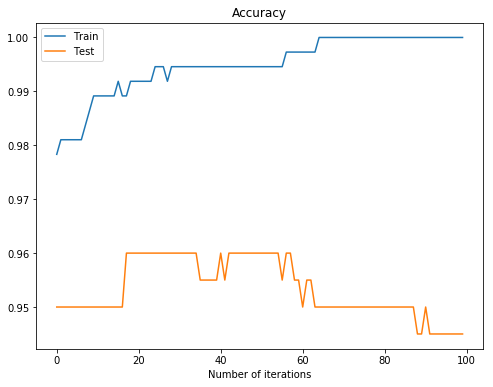

In [16]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

You can see that there is model overfitting, and there is a decrease in model accuracy after about 60 iterations 

Select the trained model obtained after 30 iterations.

In [17]:
# Select trained model.
n_trees = 30
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 96.0%


**Note:** You will use the accuracy value obtained on the test data to compare the accuracy of the model with default parameters to the accuracy of the model with tuned parameters.

#### 3.2.2. Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will the optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the search.

In [19]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0], 'reg_lambda': [0.0, 1.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters over the parameters values that were specified in the previous section.

In [21]:
# Search for the best parameters.
clf = GridSearchCV(xgb_model_gs, parameters, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, refit=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [0.0, 1.0], 'reg_lambda': [0.0, 1.0], 'n_estimators': [30], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

From the grid scores, you can see the performance result of all parameter combinations including the best parameter combination based on model performance.

In [22]:
# View the performance result.
clf.grid_scores_

[mean: 0.94580, std: 0.01698, params: {'n_estimators': 30, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'seed': 1337},
 mean: 0.94851, std: 0.02311, params: {'n_estimators': 30, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'seed': 1337},
 mean: 0.95122, std: 0.02637, params: {'n_estimators': 30, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337},
 mean: 0.95122, std: 0.02637, params: {'n_estimators': 30, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 1337}]

Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [23]:
print("Best score: %.1f%%" % (clf.best_score_*100))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 95.1%
Best parameter set: {'n_estimators': 30, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337}


Display the accuracy of best parameter combination on the test set.

In [24]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 96.0%


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy on test set is about the same for tuned model as it is for the trained model that has default hyperparameters values, even though the selected hyperparameters are different to the default parameters.

#### 3.2.3. Model with pipeline data preprocessing

Here you learn how to use the XGBoost model within the scikit-learn pipeline. 

Let's start by importing the required objects.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=10)
xgb_model_pca = XGBClassifier(n_estimators=n_trees)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

Now you are ready to evaluate accuracy of the model trained on the reduced set of features.

In [28]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 95.5%


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


You can see that this model has a similar accuracy to the model trained using default hyperparameter values.

Let's see how you can save your XGBoost pipeline using the WML service instance and deploy it for online scoring.

<a id="persistence"></a>
## 4. Persist model

In this section you learn how to use the Python client libraries to store your XGBoost model in the WML repository.

First, you must import client libraries.

In [29]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install watson-machine-learning-client --upgrade

In [31]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate to the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the [Service Credentials](https://console.bluemix.net/docs/services/service_credentials.html#service_credentials) tab of the service instance that you created on IBM Cloud. <BR>If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [32]:
#wml_credentials = {
 # "url": "https://ibm-watson-ml.mybluemix.net",
  #"access_key": "***",
  #"username": "***",
  #"password": "***",
  #"instance_id": "***"
#}

In [33]:
# The code was removed by DSX for sharing.

In [34]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.1. Save the XGBoost model to the WML Repository

Save the model artifact as *XGBoost model for breast cancer* to your WML instance.

In [35]:
model_props = {client.repository.ModelMetaNames.NAME: "XGBoost model for breast cancer"}
model_details = client.repository.store_model(pipeline, model_props)

Get the saved model metadata from WML.

# 5. Deploy and score in the IBM Cloud


In this section you will learn how to use WML to create online scoring and score a new data record.

You can list all stored models using the  `list_models` method.

In [36]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  -----------------
GUID                                  NAME                             CREATED                   FRAMEWORK
6b76f1d7-aff2-445d-b816-0c4c573fbf7d  Product Line Prediction          2018-02-18T19:51:57.776Z  mllib-2.0
4b7c9d27-6ca3-4b89-b726-9dd32ccb3958  Tumor_Type_Detection_v1_pipe     2018-03-18T23:37:40.678Z  scikit-learn-0.19
7c60098c-5c16-47f8-89e6-f72a629a9bff  My cool mnist model              2018-03-19T09:42:42.204Z  tensorflow-1.5
5999a2d9-e22c-424e-839f-d1f9c37ba8c0  XGBoost model for breast cancer  2018-03-29T14:00:39.597Z  scikit-learn-0.19
bc1104f5-9bba-4bf4-a8cc-34eff218ae4a  XGBoost model for breast cancer  2018-04-03T10:05:17.385Z  scikit-learn-0.19
5eb68ad4-1f39-4b1f-9687-0a071907aed0  XGBoost model for breast cancer  2018-04-05T11:33:31.059Z  scikit-learn-0.19
950423e2-f164-4094-89af-44f005acaf77  XGBoost model for breast cancer  2018-04-05T12:27:33.111Z  sc

You need the model uid to create the deployment. You can extract the model uid from the saved model details.

In [37]:
# Extract the uid.
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

950423e2-f164-4094-89af-44f005acaf77


Use this modul_uid in the next section to create the deployment.

### 5.1. Create the model deployment

Now you can create a deployment, *Predict breast cancer*.

In [38]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, 'Predict breast cancer')



#######################################################################################

Synchronous deployment creation for uid: 'd8143f44-220c-4a17-a1b1-0d3f61d5d013' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d8143f44-220c-4a17-a1b1-0d3f61d5d013'
------------------------------------------------------------------------------------------------




Get a list of all deployments.

In [39]:
# List the deployments.
client.deployments.list()

------------------------------------  ----------------------  ------  --------------  ------------------------  -----------------
GUID                                  NAME                    TYPE    STATE           CREATED                   FRAMEWORK
206ce253-eaaa-40f0-9aac-bc0d25e3fe88  online                  online  DEPLOY_SUCCESS  2018-02-18T19:52:22.583Z  mllib-2.0
40f24853-f991-4aa1-9936-830f197aa758  Mnist model deployment  online  DEPLOY_SUCCESS  2018-03-19T09:42:58.735Z  tensorflow-1.5
d8143f44-220c-4a17-a1b1-0d3f61d5d013  Predict breast cancer   online  DEPLOY_SUCCESS  2018-04-05T12:27:51.539Z  scikit-learn-0.19
------------------------------------  ----------------------  ------  --------------  ------------------------  -----------------


The *Predict breast cancer model* has been successfully deployed.

### 5.2. Perform prediction

Now, extract the url endpoint, *scoring_url*, which will be used to send scoring requests.

In [40]:
# Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/950423e2-f164-4094-89af-44f005acaf77/deployments/d8143f44-220c-4a17-a1b1-0d3f61d5d013/online


Prepare the scoring payload with the values to score.

In [41]:
# Prepare scoring payload.
payload_scoring = {"values": [X_test[0].tolist()]}
print(payload_scoring)

{'values': [[12.23, 19.56, 78.54, 461.0, 0.09586, 0.08087, 0.04187, 0.04107, 0.1979, 0.06013, 0.3534, 1.326, 2.308, 27.24, 0.007514, 0.01779, 0.01401, 0.0114, 0.01503, 0.003338, 14.44, 28.36, 92.15, 638.4, 0.1429, 0.2042, 0.1377, 0.108, 0.2668, 0.08174]]}


In [42]:
# Perform prediction and display the result.
response_scoring = client.deployments.score(scoring_url, payload_scoring)
print(response_scoring)

{'fields': ['prediction', 'probability'], 'values': [[0.0, [0.9505169987678528, 0.04948299005627632]]]}


**Result**: The patient record is classified as a benign tumor.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! 

You learned how to use XGBoost machine learning as well as Watson Machine Learning to create and deploy a model. 

Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Data citations

Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Author

**Wojciech Sobala** is a Data Scientist at IBM.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>